# 이미지 생성 Image Generation
이번 노트북에서는 지난 시간에 이어 이미지 미분값에 대한 탐구를 계속한다.   
이번에도 TinyImageNet에 기 훈련된(pretrained)모델을 사용한다. 

이미지 생성을 위해 이 이미지 미분을 사용하는 여러 기법을 알아 볼 것이다.
구현할 내용은 다음과 같다.  
 - 클래스 시각화 (class visualizations)
 - 피쳐 뒤집기(feature inversion)
 - 깊은 꿈(DeepDream)

In [111]:
%%javascript
var fname = document.body.attributes['data-notebook-name'].value
var fpath = document.body.attributes['data-notebook-path'].value.replace(/^local/, '/root').replace(fname, '')
IPython.notebook.kernel.execute("theNoteBookDir = '" + fpath + "'" );

<IPython.core.display.Javascript object>

In [112]:
import os
os.chdir(theNoteBookDir)

In [113]:
# 언제나 처럼, 약간의 셋업이 필요하다

import time, os, json
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

from cs231n.classifiers.pretrained_cnn import PretrainedCNN
from cs231n.data_utils  import load_tiny_imagenet
from cs231n.image_utils import blur_image, deprocess_image, preprocess_image

%matplotlib inline
plt.rcParams['figure.figsize']      = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap']          = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TinyImageNet 과 기 훈련된(pretrained) 모델
이전 노트북 처럼,  TinyImageNet 데이터셋과 기 훈련된 모델을 로드한다.

In [114]:
data  = load_tiny_imagenet('cs231n/datasets/tiny-imagenet-100-A', subtract_mean=True)
model = PretrainedCNN(h5_file='cs231n/datasets/pretrained_model.h5')

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


# 클래스 시각화

무작위 잡음 이미지를 시작점으로 해서 해당 클래스에 대한 기울기 상승 알고리즘을 수행한다. 이렇게 생성된 이미지 역시 해당 클래스로 인식될 것이다.  
이 아이디어는  논문 [1]에서 처음 소개되었다. 논문 [2]에서는 이 아이디어를 더 확장하였다. 그 논문에서는 정규화 기법을 제안해서 더 고퀄 이미지를 만들었다.  

---
좀 더 구체적으로 설명하기 위해 기호를 정의하자,  
- $ I $ : 이미지 
- $ y $ : 타겟 클래스
- $ s_y(I) $ : 이미지 $I$ 를 CNN에 돌렸을 때 $y$ 클래스에 대응되는 스코어  
   이 스코어 값은 소프트맥스를 취하기 전의 값. 즉 정규화 되지 않은 값임을 유의하라.  
- $ I^* $ : 생성하고 싶은 이미지. 이 이미지는 클래스 $y$ 에 대해 매우 높은 스코어 값을 갖기를 원함. 
    
---
최적화 문제로 접근하기
- 아래와 같이 최적화 문제로 $I^*$ 값을 정의할 수 있다.  
  $ I^* = argmax _I  $ $ \{s_y(I) + R(I) \} $ 
- $R$: (암시적으로 가능한  possibly implicit. 드롭아웃 류라고 보면 될 듯) 정규화 함수    
  여기서는 명시적인 L2 정규화와 논문[2] 에서 제안한 (암시적인) 정규화를 동시에 사용할 것이다.  
  추가된 (암시적) 정규화 요소는 이미지에 주기적으로 블러링 효과 입히도록 설정한다.
  - 즉, 정규화 요소 = $ R(I) +  \lambda \|I\|_2^2 $
- 최솟값이 아닌 최대값 문제이므로 기울기 하강이 아닌   
  기울기 상승 알고리즘으로 위의 최적화 문제를 풀 수 있다.  
- 미분값 계산. 생성하는 이미지에 대해서 오브젝티브 함수의 미분값을 계산하면 된다.
  - Objective =  $ s_y(I) + R(I) +  \lambda \|I\|_2^2 $  이므로   
    벡터 I에 대해 미분을 해 보면 다음과 같다.(dK 는 dK/dI 편미분 값을 약식 표기한 것)     
    dOjbective = $ ds_y(I) + dR(I) +  2 * \lambda \|I\|_2 $  
- 미분 계산 코드 구현 
  - $ ds_y(I) $ 는 스코어에 대한 미분값이므로  
    dscore(맨 마지막 레이어에서의 스코어 미분값)를 backpropataion함수에 넣어서 구한다  
    단, 일반적인 dscore 가 아니라 조작된 dscore값을 사용한다. (위의 cs21n 슬라이드 참조)
  - $ dR(I) $ 는 암시적인 정규화 요소라서 수식으로 구하지 않고   
  - $ d \lambda \|I\|_2^2 $ =  $ 2* \lambda *I $  인데  (식을 유도하고 코딩하기 복잡해 보일 수 있으나)   
    이미 assignment #1 부터 계속 했으므로  
    assignment1/cs231n/classifiers/neural_net.py 등의 loss함수에서 dW 구하는 부분 구현 참조하면 된다. 
                   
---
아래 셀의  `create_class_visualization` 함수 구현을 완성하라.

---
참고 문헌
- 논문[1]: Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman.   
  "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps",  ICLR Workshop 2014.

- 논문[2]: Yosinski et al,  
  "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

- cs231n: Lecture 9.  ![image](https://cloud.githubusercontent.com/assets/1628848/20622587/f51f2e58-b346-11e6-80ab-0a03cc43e33f.png)

In [109]:
def create_class_visualization(target_y, model, **kwargs):
    """
    Perform optimization over the image to generate class visualizations.
    클래스 시각화를 위해서 해당 이미지에 대한 최적화를 수행.
      
    입력:
      - target_y: [0, 100) 범위의 정수. 타켓 클래스를 의미.
      - model   : 기 훈련된 CNN 모델, 이미지 생성에 사용함.
  
     ** kwargs 인자값
      - learning_rate  : learning rate (float)
      - blur_every     : 이미지에 대한 블러 정규화 빈도(integer)
      - l2_reg         : 이미지에 대한 L2   정규화 강도. 위 최적화 수식에서의 λ값 (float)
      - max_jitter     : 무작위 지터(jitter) 강도. 이미지 전처리 정규화 성분.
      - num_iterations : run 수행 반복횟수
      - show_every     : 이미지 보여주는 빈도
    출력:
      - X : 생성된 이미지 (1, 3, 64, 64)
    """
                               # 패러미터 이름,   기본값
    learning_rate  = kwargs.pop('learning_rate',  10000)
    blur_every     = kwargs.pop('blur_every',     1)
    l2_reg         = kwargs.pop('l2_reg',         1e-6)
    max_jitter     = kwargs.pop('max_jitter',     4)
    num_iterations = kwargs.pop('num_iterations', 100)
    show_every     = kwargs.pop('show_every',     25)
  
    X = np.random.randn(1, 3, 64, 64)
    for t in xrange(num_iterations):        
        # 정규화를 위해, 무작위 지터를 이미지에 수행한다.
        #    구간 [-max_jitter, max_jitter+1) 에서 2개의 값을 꺼낸다. 
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2) 
        #    ox 만큼  height 방향으로 r-rotate, oy 만큼 width 방향으로 r-rotate 시킨다.  
        X = np.roll(np.roll(X, ox, -1), oy, -2)

        dX = None
        ############################################################################
        # TODO: target_y 클래스 스코에 대한  이미지 미분값 dX 를 계산하라.         #
        # 저번 시간에 했던 '거짓 이미지' 와 유사하다.                              #
        # 단, L2 정규화 값을 dX에 더한 후에,                                       #
        # learning_rate를 이용해서 이미지 x를 업데이트 하라.                       #
        ############################################################################
        
        # 1. 스코어 부분 미분값 dsy 구하기. 
        score,  cache = model.forward(X)  
        dscore        = np.zeros_like(score)        # (1, 100)               
        dscore[0, target_y] = 1        
        dsy  = model.backward(dscore, cache)[0]
        
        # 2.  L2 정규화 부분 미분값 dL2R 구하기
        dL2R = 2 * l2_reg * X
        
        # 3. 오브젝티브 함수 전체 미분 값 구하기. 
        dX   = dsy + dL2R
        
        # 4. 이미지에 미분값 (양의 방향으로) 더하기
        X   += dX * learning_rate               
        ############################################################################
        #                            작성한 코드 끝                                #
        ############################################################################
    
        # 지터효과를 다시 복원시킨다. 
        X = np.roll(np.roll(X, -ox, -1), -oy, -2)
    
        # 정규화를 위해, 이미지를 자른다
        X = np.clip(X, -data['mean_image'], 255.0 - data['mean_image'])
    
        # 정규화를 위해, 주기적으로 블러 효과를 적용한다.
        if (t+1) % blur_every == 0:
            X = blur_image(X)
    
        # 주기적으로 중간 이미지를 그린다.
        if (t+1) % show_every == 0:
            print 'iter:', t+1, '/', num_iterations
            plt.imshow(deprocess_image(X, data['mean_image']))
            plt.gcf().set_size_inches(3, 3)
            plt.axis('off')
            plt.show()
    return X

위의 코드를 이용하면 아티슥한 이미지 생성이 가능하다!   
아래 예제를 통해 생성해 보자.
Yosinski et al  논문[2]에서 제안한 다른 정규화 방법을 시도해 볼 수 있지만 안 해 봐도 된다.

['tarantula']
default  parameter:
iter: 25 / 100


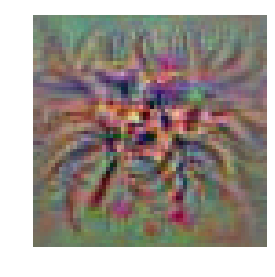

iter: 50 / 100


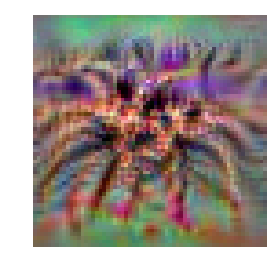

iter: 75 / 100


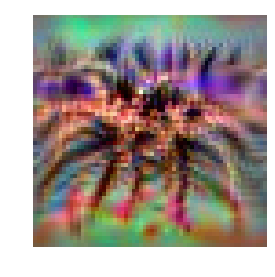

iter: 100 / 100


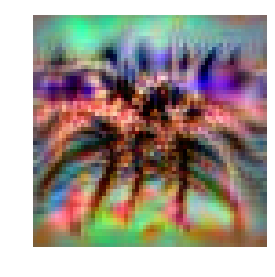

jitter = off:
iter: 100 / 100


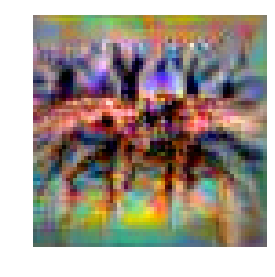

blur = off:
iter: 100 / 100


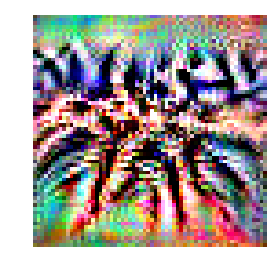

learning_rate /=2 , num_iteration *= 2:
iter: 200 / 200


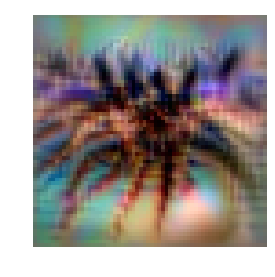

learning_rate /=2 , num_iteration *= 2, jitter /=2:
iter: 200 / 200


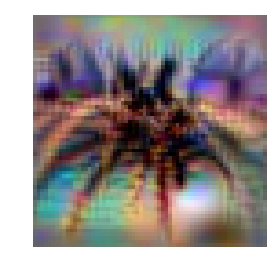

learning_rate /=2 , num_iteration *= 2, jitter /=2, bulr/= 2:
iter: 200 / 200


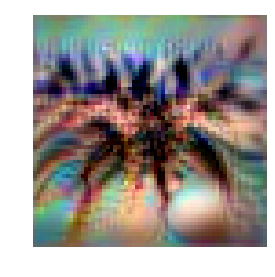

In [108]:
target_y = 43 # 타란툴라(독거미의 일종)
print data['class_names'][target_y]
print '====================\ndefault  parameter:'
X = create_class_visualization(target_y, model, show_every=25)

print '=====================\njitter = off:'
X = create_class_visualization(target_y, model, show_every= 100, max_jitter = 0)

print '=====================\nblur = off:'
X = create_class_visualization(target_y, model, show_every= 100, blur_every = 101)

print '=====================\nlearning_rate /=2 , num_iteration *= 2:'
X = create_class_visualization(target_y, model, show_every= 200, num_iterations = 200, learning_rate = 5000)

print '=====================\nlearning_rate /=2 , num_iteration *= 2, jitter /=2:'
X = create_class_visualization(target_y, model, show_every= 200, num_iterations = 200, learning_rate = 5000, max_jitter = 2)

print '=====================\nlearning_rate /=2 , num_iteration *= 2, jitter /=2, bulr/= 2:'
X = create_class_visualization(target_y, model, show_every= 200, num_iterations = 200, learning_rate = 5000, max_jitter = 2, blur_every = 2)

# 피처로 그림 만들기: Feature Inversion
CNN이 인식을 위해 학습한 피처 타입을 이해하기 위한 시도가 있었다.  최근 논문 [1] 에서는 피처 표현으로부터 이미지를 재구성했다. 이 아이디어는 기 학습된 모델로 이미지 미분값을 구하는 방식으로 쉽게 구현된다. 
 
---
좀 더 구체적으로 설명하기 위해 기호를 정의하자,,
given a image $I$, let $\phi_\ell(I)$ be the activations at layer $\ell$ of the convolutional network $\phi$. We wish to find an image $I^*$ with a similar feature representation as $I$ at layer $\ell$ of the network $\phi$ by solving the optimization problem

$$
I^* = \arg\min_{I'} \|\phi_\ell(I) - \phi_\ell(I')\|_2^2 + R(I')
$$

where $\|\cdot\|_2^2$ is the squared Euclidean norm. As above, $R$ is a (possibly implicit) regularizer. We can solve this optimization problem using gradient descent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I') + \lambda \|I'\|_2^2
$$

together with implicit regularization by periodically blurring the image, as recommended by [2].

Implement this method in the function below.

[1] Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting them", CVPR 2015

[2] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [ ]:
def invert_features(target_feats, layer, model, **kwargs):
  """
  Perform feature inversion in the style of Mahendran and Vedaldi 2015, using
  L2 regularization and periodic blurring.
  
  Inputs:
  - target_feats: Image features of the target image, of shape (1, C, H, W);
    we will try to generate an image that matches these features
  - layer: The index of the layer from which the features were extracted
  - model: A PretrainedCNN that was used to extract features
  
  Keyword arguments:
  - learning_rate: The learning rate to use for gradient descent
  - num_iterations: The number of iterations to use for gradient descent
  - l2_reg: The strength of L2 regularization to use; this is lambda in the
    equation above.
  - blur_every: How often to blur the image as implicit regularization; set
    to 0 to disable blurring.
  - show_every: How often to show the generated image; set to 0 to disable
    showing intermediate reuslts.
    
  Returns:
  - X: Generated image of shape (1, 3, 64, 64) that matches the target features.
  """
  learning_rate = kwargs.pop('learning_rate', 10000)
  num_iterations = kwargs.pop('num_iterations', 500)
  l2_reg = kwargs.pop('l2_reg', 1e-7)
  blur_every = kwargs.pop('blur_every', 1)
  show_every = kwargs.pop('show_every', 50)
  
  X = np.random.randn(1, 3, 64, 64)
  for t in xrange(num_iterations):
    ############################################################################
    # TODO: Compute the image gradient dX of the reconstruction loss with      #
    # respect to the image. You should include L2 regularization penalizing    #
    # large pixel values in the generated image using the l2_reg parameter;    #
    # then update the generated image using the learning_rate from above.      #
    ############################################################################
    pass
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    
    # As a regularizer, clip the image
    X = np.clip(X, -data['mean_image'], 255.0 - data['mean_image'])
    
    # As a regularizer, periodically blur the image
    if (blur_every > 0) and t % blur_every == 0:
      X = blur_image(X)

    if (show_every > 0) and (t % show_every == 0 or t + 1 == num_iterations):
      plt.imshow(deprocess_image(X, data['mean_image']))
      plt.gcf().set_size_inches(3, 3)
      plt.axis('off')
      plt.title('t = %d' % t)
      plt.show()

### Shallow feature reconstruction
After implementing the feature inversion above, run the following cell to try and reconstruct features from the fourth convolutional layer of the pretrained model. You should be able to reconstruct the features using the provided optimization parameters.

In [ ]:
filename = 'kitten.jpg'
layer = 3 # layers start from 0 so these are features after 4 convolutions
img = imresize(imread(filename), (64, 64))

plt.imshow(img)
plt.gcf().set_size_inches(3, 3)
plt.title('Original image')
plt.axis('off')
plt.show()

# Preprocess the image before passing it to the network:
# subtract the mean, add a dimension, etc
img_pre = preprocess_image(img, data['mean_image'])

# Extract features from the image
feats, _ = model.forward(img_pre, end=layer)

# Invert the features
kwargs = {
  'num_iterations': 400,
  'learning_rate': 5000,
  'l2_reg': 1e-8,
  'show_every': 100,
  'blur_every': 10,
}
X = invert_features(feats, layer, model, **kwargs)

### Deep feature reconstruction
Reconstructing images using features from deeper layers of the network tends to give interesting results. In the cell below, try to reconstruct the best image you can by inverting the features after 7 layers of convolutions. You will need to play with the hyperparameters to try and get a good result.

HINT: If you read the paper by Mahendran and Vedaldi, you'll see that reconstructions from deep features tend not to look much like the original image, so you shouldn't expect the results to look like the reconstruction above. You should be able to get an image that shows some discernable structure within 1000 iterations.

In [ ]:
filename = 'kitten.jpg'
layer = 6 # layers start from 0 so these are features after 7 convolutions
img = imresize(imread(filename), (64, 64))

plt.imshow(img)
plt.gcf().set_size_inches(3, 3)
plt.title('Original image')
plt.axis('off')
plt.show()

# Preprocess the image before passing it to the network:
# subtract the mean, add a dimension, etc
img_pre = preprocess_image(img, data['mean_image'])

# Extract features from the image
feats, _ = model.forward(img_pre, end=layer)

# Invert the features
# You will need to play with these parameters.
kwargs = {
  'num_iterations': 1000,
  'learning_rate': 0,
  'l2_reg': 0,
  'show_every': 100,
  'blur_every': 0,
}
X = invert_features(feats, layer, model, **kwargs)

# DeepDream
In the summer of 2015, Google released a [blog post](http://googleresearch.blogspot.com/2015/06/inceptionism-going-deeper-into-neural.html) describing a new method of generating images from neural networks, and they later [released code](https://github.com/google/deepdream) to generate these images.

The idea is very simple. We pick some layer from the network, pass the starting image through the network to extract features at the chosen layer, set the gradient at that layer equal to the activations themselves, and then backpropagate to the image. This has the effect of modifying the image to amplify the activations at the chosen layer of the network.

For DeepDream we usually extract features from one of the convolutional layers, allowing us to generate images of any resolution.

We can implement this idea using our pretrained network. The results probably won't look as good as Google's since their network is much bigger, but we should still be able to generate some interesting images.

In [ ]:
def deepdream(X, layer, model, **kwargs):
  """
  Generate a DeepDream image.
  
  Inputs:
  - X: Starting image, of shape (1, 3, H, W)
  - layer: Index of layer at which to dream
  - model: A PretrainedCNN object
  
  Keyword arguments:
  - learning_rate: How much to update the image at each iteration
  - max_jitter: Maximum number of pixels for jitter regularization
  - num_iterations: How many iterations to run for
  - show_every: How often to show the generated image
  """
  
  X = X.copy()
  
  learning_rate = kwargs.pop('learning_rate', 5.0)
  max_jitter = kwargs.pop('max_jitter', 16)
  num_iterations = kwargs.pop('num_iterations', 100)
  show_every = kwargs.pop('show_every', 25)
  
  for t in xrange(num_iterations):
    # As a regularizer, add random jitter to the image
    ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
    X = np.roll(np.roll(X, ox, -1), oy, -2)

    dX = None
    ############################################################################
    # TODO: Compute the image gradient dX using the DeepDream method. You'll   #
    # need to use the forward and backward methods of the model object to      #
    # extract activations and set gradients for the chosen layer. After        #
    # computing the image gradient dX, you should use the learning rate to     #
    # update the image X.                                                      #
    ############################################################################
    pass
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    
    # Undo the jitter
    X = np.roll(np.roll(X, -ox, -1), -oy, -2)
    
    # As a regularizer, clip the image
    mean_pixel = data['mean_image'].mean(axis=(1, 2), keepdims=True)
    X = np.clip(X, -mean_pixel, 255.0 - mean_pixel)
    
    # Periodically show the image
    if t == 0 or (t + 1) % show_every == 0:
      img = deprocess_image(X, data['mean_image'], mean='pixel')
      plt.imshow(img)
      plt.title('t = %d' % (t + 1))
      plt.gcf().set_size_inches(8, 8)
      plt.axis('off')
      plt.show()
  return X

# Generate some images!
Try and generate a cool-looking DeepDeam image using the pretrained network. You can try using different layers, or starting from different images. You can reduce the image size if it runs too slowly on your machine, or increase the image size if you are feeling ambitious.

In [ ]:
def read_image(filename, max_size):
  """
  Read an image from disk and resize it so its larger side is max_size
  """
  img = imread(filename)
  H, W, _ = img.shape
  if H >= W:
    img = imresize(img, (max_size, int(W * float(max_size) / H)))
  elif H < W:
    img = imresize(img, (int(H * float(max_size) / W), max_size))
  return img

filename = 'kitten.jpg'
max_size = 256
img = read_image(filename, max_size)
plt.imshow(img)
plt.axis('off')

# Preprocess the image by converting to float, transposing,
# and performing mean subtraction.
img_pre = preprocess_image(img, data['mean_image'], mean='pixel')

out = deepdream(img_pre, 7, model, learning_rate=2000)